In [2]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


# .env 読み込み
print(r"..\environment\.env")
load_dotenv(dotenv_path=r'..\environment/.env',override=True)

# =========================
# 🔐 Metabase 認証・データ取得
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("❌ MB_USERNAME または MB_PASSWORD が設定されていません")

print(f"ログイン試行中 → username: '{username}'")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("✅ ログイン成功")
else:
    raise Exception(f"❌ ログイン失敗: {response.status_code}, {response.text}")


..\environment\.env
ログイン試行中 → username: 'y-nitta@torishima.co.jp'
✅ ログイン成功


In [3]:

# データ取得
url = "https://metabase.tr-com.net/api/card/2091/query/json"
headers = {
    "Content-Type": "application/json",
    "X-Metabase-Session": session_id
}

# Payload
payload = {
    "parameters": [
        {
            "type": "category",
            "target": ["variable", ["template-tag", "sensorid"]],
            "value": "VB39660F"
        }
    ]
}


In [4]:

response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    try:
        data = response.json()
        dfori = pd.DataFrame(data)
        if dfori.empty:
            raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")
        print("✅ データ取得成功")
        print(dfori.head())

    except Exception as e:
        raise Exception(f"❌ データ取得・DataFrame変換失敗: {e}")
else:
    raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")


✅ データ取得成功
  sensortype          record_date  temperature  x_vrmsacc  x_kurtosisacc
0          M  2019-09-03T03:02:45          NaN        NaN            NaN
1          M  2019-09-03T04:35:48        23.26  43.700787            NaN
2          M  2019-09-03T04:35:48          NaN        NaN            NaN
3          M  2019-09-03T05:35:48        24.12  13.385827            NaN
4          M  2019-09-03T06:35:47        24.12  13.385827            NaN


In [5]:
dfori

,sensortype,record_date,temperature,x_vrmsacc,x_kurtosisacc
0,M,2019-09-03T03:02:45,NaN,NaN,NaN
1,M,2019-09-03T04:35:48,23.26,43.700787,NaN
2,M,2019-09-03T04:35:48,NaN,NaN,NaN
3,M,2019-09-03T05:35:48,24.12,13.385827,NaN
4,M,2019-09-03T06:35:47,24.12,13.385827,NaN
...,...,...,...,...,...
51311,M,2025-05-31T20:35:36,19.79,16.929134,22.82
51312,M,2025-05-31T21:35:36,19.70,16.929134,23.47
51313,M,2025-05-31T22:35:36,19.70,16.929134,23.87
51314,M,2025-05-31T23:35:36,19.90,16.929134,22.82


In [17]:
! pip install hmmlearn


加速度が高い、低い、徐々に高くなっている、変な値etc、を探してみる

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm

# --- 1. 前処理 ---
dfori['record_date'] = pd.to_datetime(dfori['record_date'])
df_clean = dfori.dropna(subset=['x_vrmsacc']).sort_values('record_date')

# --- 2. 特徴量整形と標準化（必要なら多軸可） ---
features = df_clean[['x_vrmsacc']]  # 例：[['x_vrmsacc', 'y_vrmsacc', 'z_vrmsacc']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- 3. 最適な状態数（n_components）を BIC で決定 ---
lowest_bic = np.inf
best_model = None
bic_scores = []

for n in range(2, 100):
    model = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=200, random_state=42)
    model.fit(X_scaled)
    log_likelihood = model.score(X_scaled)
    n_params = n * 2 + n * (n - 1)  # 平均+分散 + 遷移行列（概算）
    bic = -2 * log_likelihood + n_params * np.log(len(X_scaled))
    bic_scores.append((n, bic))
    if bic < lowest_bic:
        lowest_bic = bic
        best_model = model

best_n = best_model.n_components
print(f"✅ 推定された最適な状態数: {best_n}")

# --- 4. 状態推定 ---
df_clean['state'] = best_model.predict(X_scaled)

# --- 5. 状態ラベル（平均順に手動マッピング） ---
state_means = pd.Series(best_model.means_.flatten()).sort_values()
default_labels = ['停止中', '通常稼働', '負荷上昇', '異常 or ピーク負荷']
state_labels = {idx: default_labels[i] if i < len(default_labels) else f'状態{i}' for i, idx in enumerate(state_means.index)}
df_clean['state_label'] = df_clean['state'].map(state_labels)

# --- 6. 時系列プロット ---
plt.figure(figsize=(15, 5))
for state in sorted(df_clean['state'].unique()):
    sub = df_clean[df_clean['state'] == state]
    plt.plot(sub['record_date'], sub['x_vrmsacc'], '.', label=f"{state_labels[state]}")
plt.title('x_vrmsacc 時系列と HMM 状態分類（状態数自動選定）')
plt.xlabel('時間')
plt.ylabel('x_vrmsacc')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 7. BIC スコア確認（オプション） ---
n_values, bic_values = zip(*bic_scores)
plt.figure(figsize=(8, 4))
plt.plot(n_values, bic_values, marker='o')
plt.title("状態数ごとの BIC スコア")
plt.xlabel("状態数")
plt.ylabel("BIC")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. 出力確認 ---
print(df_clean[['record_date', 'x_vrmsacc', 'state', 'state_label']].head())


Model is not converging.  Current: 96728.84518616159 is not greater than 96729.38503452865. Delta is -0.5398483670578571


C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2339866402.py:61: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2339866402.py:61: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2339866402.py:61: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2339866402.py:61: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2339866402.py:61: UserWarning: Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2339866402.py:61: UserWarning: Glyph 12463 (\N{KATAKANA 

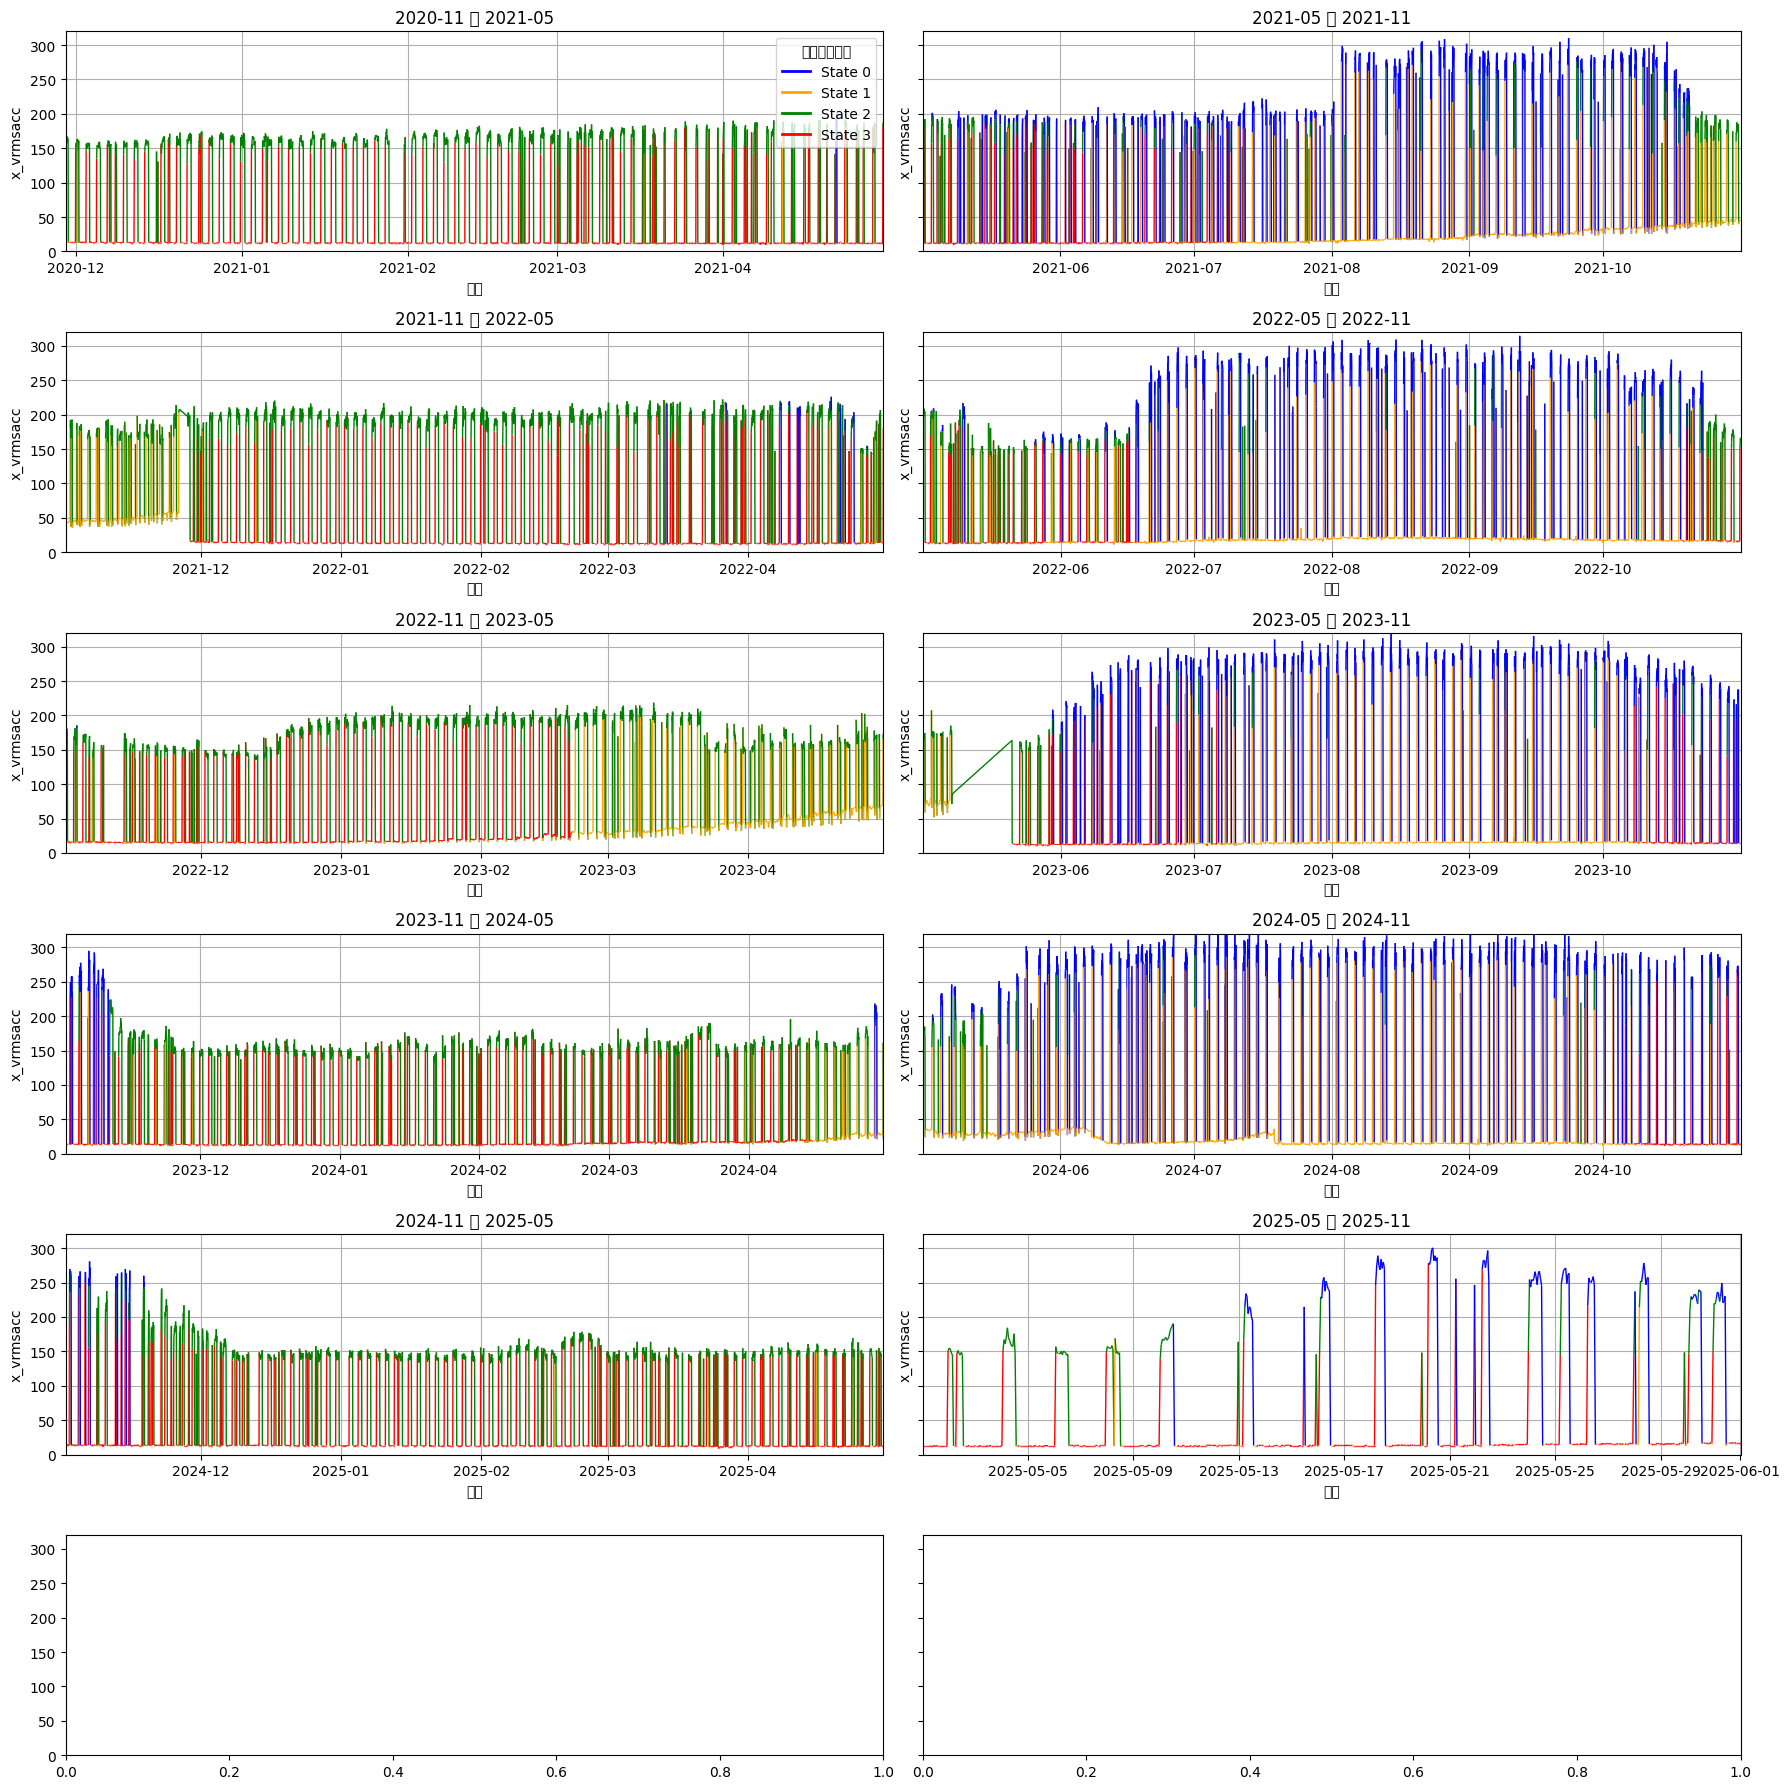

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

# カラーマップ
colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}

# 半年区切り
start_date = df_clean['record_date'].min().to_period('6M').start_time
end_date = df_clean['record_date'].max().to_period('6M').end_time
periods = pd.date_range(start=start_date, end=end_date, freq='6MS')

# サブプロット設定
n_rows = int(np.ceil(len(periods)/2))
fig, axes = plt.subplots(n_rows, 2, figsize=(18, 3 * n_rows), sharey=True)
axes = axes.flatten()

for i in range(len(periods)-1):
    start = periods[i]
    end = periods[i+1]
    mask = (df_clean['record_date'] >= start) & (df_clean['record_date'] < end)
    df_period = df_clean.loc[mask].sort_values('record_date')

    ax = axes[i]
    if df_period.empty:
        continue

    # matplotlib が扱える float 時系列に変換
    times = mdates.date2num(df_period['record_date'].to_list())
    values = df_period['x_vrmsacc'].values
    states = df_period['state'].values

    # セグメント生成
    segments = []
    segment_colors = []
    for j in range(len(values) - 1):
        seg = [(times[j], values[j]), (times[j+1], values[j+1])]
        segments.append(seg)
        segment_colors.append(colors.get(states[j], 'gray'))

    # 折れ線として描画
    lc = LineCollection(segments, colors=segment_colors, linewidths=1.0)
    ax.add_collection(lc)

    # 軸とタイトル設定
    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(0, 320)
    ax.xaxis_date()
    ax.set_title(f"{start.strftime('%Y-%m')} ～ {end.strftime('%Y-%m')}")
    ax.set_xlabel("日時")
    ax.set_ylabel("x_vrmsacc")
    ax.grid(True)

# 凡例追加（ダミー線）
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, lw=2, label=f"State {s}") for s, c in colors.items()]
axes[0].legend(handles=legend_elements, title="状態クラスタ", loc='upper right')

plt.tight_layout()
plt.show()


C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2301900183.py:60: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2301900183.py:60: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2301900183.py:60: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2301900183.py:60: UserWarning: Glyph 29366 (\N{CJK UNIFIED IDEOGRAPH-72B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2301900183.py:60: UserWarning: Glyph 24907 (\N{CJK UNIFIED IDEOGRAPH-614B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\H6445\AppData\Local\Temp\ipykernel_16120\2301900183.py:60: UserWarning: Glyph 12463 (\N{KATAKANA 

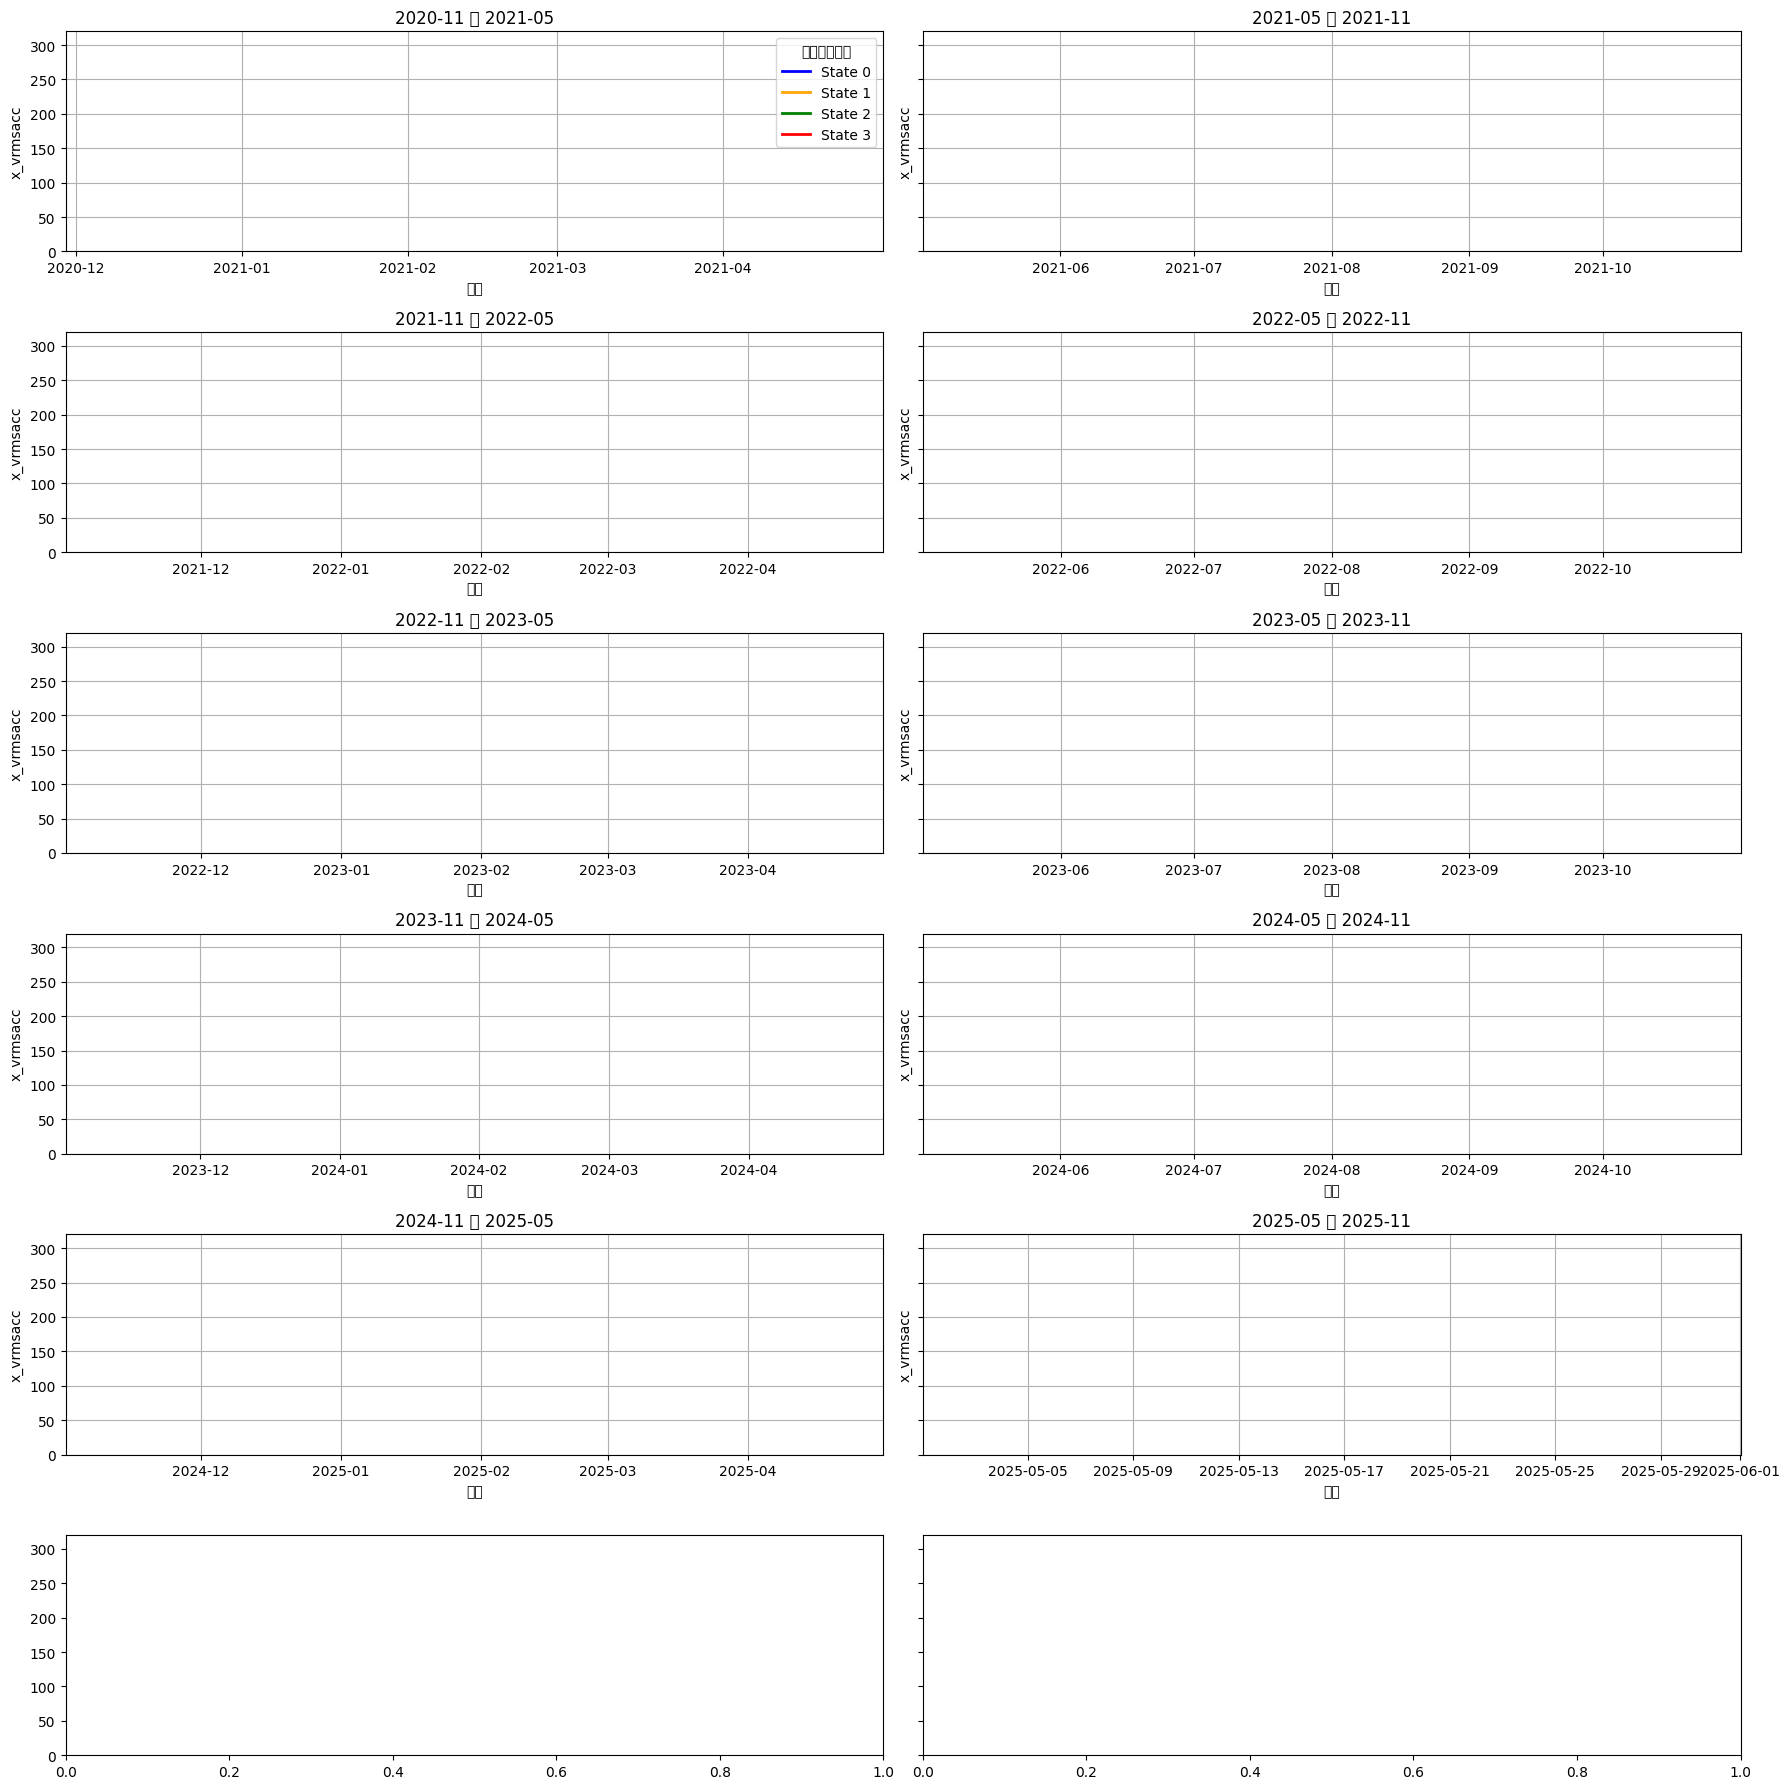

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection

# カラーマップ
colors = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}

# 半年分の期間を取得
start_date = df_clean['record_date'].min().to_period('6M').start_time
end_date = df_clean['record_date'].max().to_period('6M').end_time
periods = pd.date_range(start=start_date, end=end_date, freq='6MS')

# サブプロットの設定
n_rows = int(np.ceil(len(periods)/2))
fig, axes = plt.subplots(n_rows, 2, figsize=(18, 3 * n_rows), sharey=True)
axes = axes.flatten()

for i in range(len(periods)-1):
    start = periods[i]
    end = periods[i+1]
    mask = (df_clean['record_date'] >= start) & (df_clean['record_date'] < end)
    df_period = df_clean.loc[mask].sort_values('record_date')

    ax = axes[i]

    if df_period.empty:
        continue

    # 座標を作る
    times = df_period['record_date'].values
    values = df_period['x_vrmsacc'].values
    states = df_period['state'].values

    # セグメント生成（隣り合う点をつなぐ線）
    segments = []
    segment_colors = []
    for j in range(len(values) - 1):
        seg = [(times[j], values[j]), (times[j+1], values[j+1])]
        segments.append(seg)
        # 現在の点の状態で色を決める（あるいは平均）
        segment_colors.append(colors.get(states[j], 'gray'))

    # LineCollection で描画
    lc = LineCollection(segments, colors=segment_colors, linewidths=1.0)
    ax.add_collection(lc)

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(0, 320)
    ax.set_title(f"{start.strftime('%Y-%m')} ～ {end.strftime('%Y-%m')}")
    ax.set_xlabel("日時")
    ax.set_ylabel("x_vrmsacc")
    ax.grid(True)

# 凡例を追加（ダミー線で）
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, lw=2, label=f"State {s}") for s, c in colors.items()]
axes[0].legend(handles=legend_elements, title="状態クラスタ", loc='upper right')

plt.tight_layout()
plt.show()
